In [1]:
import matplotlib.pyplot as plt
from Bin_Helpers import *
import numpy as np
import os

In [5]:
fid_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_x_wl/raw_cross_cls/'

all_files = np.array(os.listdir(fid_dir))
fid_inds = [i for i, s in enumerate(all_files) if s.startswith('f')]
all_fid_files = all_files[fid_inds]
i=0
survey='Planck_x_dr3'
test = np.append(np.load(fid_dir + all_fid_files[i], allow_pickle=True).item()[survey+'_low_z'], np.load(fid_dir + all_fid_files[i], allow_pickle=True).item()[survey+'_high_z'])

In [7]:
len(test)

6144

In [11]:
all_covs = np.load('Splits_Data/Cross/WPH_Planck_x_dr3_contours_90_per.npy')

In [12]:
covs = all_covs[:,1,:,:]
covs_orig = all_covs[:,0,:,:]

In [13]:
# plt.figure(dpi = 120)
# plt.hist(np.linalg.det(covs_orig)/np.average(np.linalg.det(covs_orig)),bins=20)
# plt.show()

In [14]:
np.linalg.det(np.average(covs_orig, axis=0))/np.linalg.det(np.average(covs, axis=0))

9.759824619472548

In [18]:
np.sqrt(np.average(covs_orig, axis=0)[1,1] / np.average(covs, axis=0)[1,1])

1.4444341717386031

In [18]:
cov_det_rats = np.zeros(len(covs))
cov_det = np.zeros(len(covs))
cov_det_orig = np.zeros(len(covs))
for i in np.arange(len(covs)):
    cov_det_rats[i] = np.linalg.det(covs_orig[i]) / np.linalg.det(covs[i])
    cov_det[i] = np.linalg.det(covs[i])
    cov_det_orig[i] = np.linalg.det(covs_orig[i])

In [19]:
len(np.where(cov_det_rats>1)[0])/len(cov_det_rats)

0.467

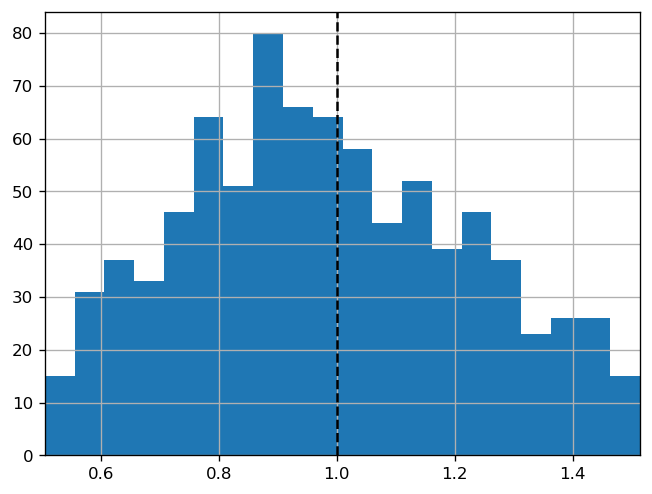

In [20]:
ave_rat = np.average(cov_det_rats)
plt.figure(dpi = 120)
plt.hist(cov_det_rats, bins = np.linspace(0.5*ave_rat, 1.5*ave_rat, 21))
plt.axvline(x=1, color='k', linestyle='--')
plt.grid()
plt.xlim([0.5*ave_rat, 1.5*ave_rat])
plt.show()

In [21]:
np.median(cov_det_rats)

0.9737914636881573

In [22]:
len(np.unique(cov_det_orig))

1000

In [23]:
len(np.unique(cov_det))

1000

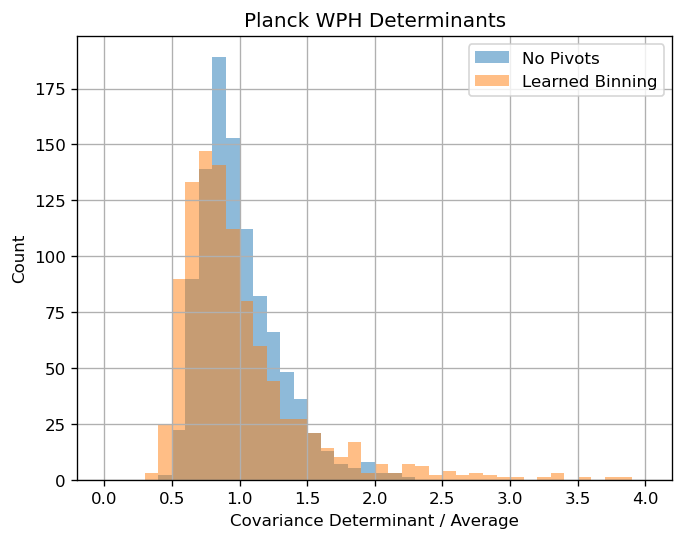

In [24]:
plt.figure(dpi = 120)
plt.hist(cov_det_orig/np.average(cov_det_orig), bins=np.linspace(0, 4, 41), alpha=0.5, label = 'No Pivots')
plt.hist(cov_det/np.average(cov_det), bins=np.linspace(0, 4, 41), alpha=0.5, label = 'Learned Binning')
plt.legend()
plt.grid()
plt.xlabel('Covariance Determinant / Average')
plt.ylabel('Count')
plt.title('Planck WPH Determinants')
plt.show()

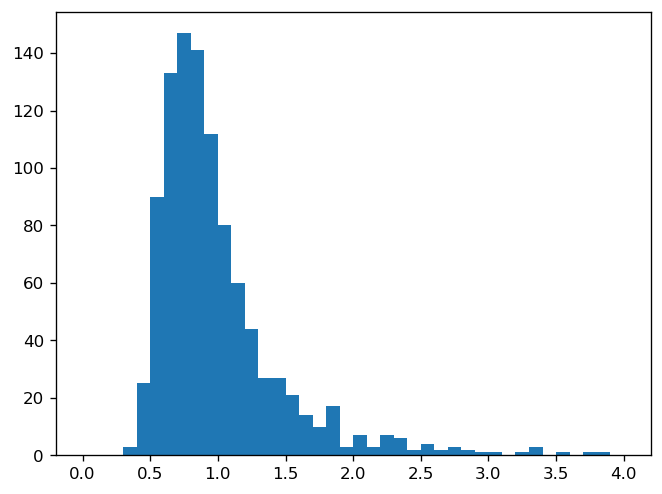

In [13]:
plt.figure(dpi = 120)
plt.hist(cov_det/np.average(cov_det), bins=np.linspace(0, 4, 41))
plt.show()

In [1]:
import sys
sys.path.append('/n/home09/kboone/CompressedFisher/')
sys.path.append('/n/home09/kboone/software/Dimension_Reduction/')

from scipy.optimize import differential_evolution, minimize
from multiprocessing import Pool
from Bin_Helpers import *
import CompressedFisher
import numpy as np
import os

In [2]:
num_Derivs = 100
survey = 'Planck_x_dr3'

In [3]:
per = 90

wph_data_len = 392

lmin = 2
lmax = 3072 # Must be 3072 or less
cro_data_len = (lmax-lmin) * 2 # Two tomographic bins

numBins = 15
compress_frac_split = 0.5
realizations = 100000 # This is for realizations on the combined Fisher
deriv_params = ['Om', 's8']

sortInds = np.load('/n/home09/kboone/software/Data/MCMC_Sorting/WPH_J7_L4_Inds.npy')

piv_dir = '/n/home09/kboone/software/Half_Data/Splits_Data/Cross/'
write_file = piv_dir+'Both_'+str(num_Derivs)+'_'+survey+'_contours.npy'

wph_piv_file = piv_dir+'WPH_'+str(num_Derivs)+'_'+survey+'.npy'
all_wph_pivots = np.load(wph_piv_file)

cro_piv_file = piv_dir+'Cl_'+str(num_Derivs)+'_'+survey+'.npy'
all_cro_pivots = np.load(cro_piv_file)

fid_split_file = piv_dir+'Fid_Splits.npy'
all_fid_splits = np.load(fid_split_file)

deriv_split_file = piv_dir+'Deriv_Splits_'+str(num_Derivs)+'.npy'
all_deriv_splits = np.load(deriv_split_file)

wph_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_x_wl/'+survey+'_wph_j7_l4/'

wph_files = np.array(os.listdir(wph_dir))
wph_fid_inds = [i for i, s in enumerate(wph_files) if s.startswith('f')]
wph_fid_files = wph_files[wph_fid_inds]
wph_Om_inds = [i for i, s in enumerate(wph_files) if s.startswith('O')]
wph_s8_inds = [i for i, s in enumerate(wph_files) if s.startswith('s')]
wph_Om_files = wph_files[wph_Om_inds]
wph_s8_files = wph_files[wph_s8_inds]
wph_Om_files = np.array([name for name in wph_Om_files if 'f' not in name])
wph_s8_files = np.array([name for name in wph_s8_files if 'f' not in name])

wph_fid = np.zeros((len(wph_fid_files), wph_data_len), dtype = np.float64)
for i in np.arange(len(wph_fid)):
    wph_fid[i] = (np.load(wph_dir + wph_fid_files[i], allow_pickle=True)[:wph_data_len].real)[sortInds]

wph_ave_fid = np.average(wph_fid, axis=0)
wph_std_fid = np.std(wph_fid, axis=0)
wph_fid = (wph_fid-wph_ave_fid) / wph_std_fid

wph_partial_Om = np.zeros((num_Derivs, wph_data_len), dtype = np.float64)
for i in np.arange(num_Derivs):
    wph_partial_Om[i] = (np.load(wph_dir + wph_Om_files[i], allow_pickle=True)[:wph_data_len].real)[sortInds]

wph_partial_Om = wph_partial_Om / wph_std_fid

wph_partial_s8 = np.zeros((num_Derivs, wph_data_len), dtype = np.float64)
for i in np.arange(num_Derivs):
    wph_partial_s8[i] = (np.load(wph_dir + wph_s8_files[i], allow_pickle=True)[:wph_data_len].real)[sortInds]

wph_partial_s8 = wph_partial_s8 / wph_std_fid


cro_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_x_wl/raw_cross_cls/'

cro_files = np.array(os.listdir(cro_dir))
cro_fid_inds = [i for i, s in enumerate(cro_files) if s.startswith('f')]
cro_fid_files = cro_files[cro_fid_inds]
cro_Om_inds = [i for i, s in enumerate(cro_files) if s.startswith('O')]
cro_s8_inds = [i for i, s in enumerate(cro_files) if s.startswith('s')]
cro_Om_files = cro_files[cro_Om_inds]
cro_s8_files = cro_files[cro_s8_inds]
cro_Om_files = np.array([name for name in cro_Om_files if 'f' not in name])
cro_s8_files = np.array([name for name in cro_s8_files if 'f' not in name])

cro_fid = np.zeros((len(cro_fid_files), cro_data_len), dtype = np.float64)
for i in np.arange(len(cro_fid)):
    cro_fid[i] = np.append(np.load(cro_dir + cro_fid_files[i], allow_pickle=True).item()[survey+'_low_z'][lmin:lmax], np.load(cro_dir + cro_fid_files[i], allow_pickle=True).item()[survey+'_high_z'][lmin:lmax])

cro_ave_fid = np.average(cro_fid, axis=0)
cro_std_fid = np.std(cro_fid, axis=0)
cro_fid = (cro_fid-cro_ave_fid) / cro_std_fid

cro_partial_Om = np.zeros((num_Derivs, cro_data_len), dtype = np.float64)
for i in np.arange(num_Derivs):
    cro_partial_Om[i] = np.append(np.load(cro_dir + cro_Om_files[i], allow_pickle=True).item()[survey+'_low_z'][lmin:lmax], np.load(cro_dir + cro_Om_files[i], allow_pickle=True).item()[survey+'_high_z'][lmin:lmax])
cro_partial_Om = cro_partial_Om / cro_std_fid

cro_partial_s8 = np.zeros((num_Derivs, cro_data_len), dtype = np.float64)
for i in np.arange(num_Derivs):
    cro_partial_s8[i] = np.append(np.load(cro_dir + cro_s8_files[i], allow_pickle=True).item()[survey+'_low_z'][lmin:lmax], np.load(cro_dir + cro_s8_files[i], allow_pickle=True).item()[survey+'_high_z'][lmin:lmax])
cro_partial_s8 = cro_partial_s8 / cro_std_fid

In [4]:
realization = 0

fid_split = ~all_fid_splits[realization]
deriv_split = ~all_deriv_splits[realization]
wph_pivots = all_wph_pivots[realization]
cro_pivots = all_cro_pivots[realization]

wph_Q = create_linlin_matrix(wph_data_len, numBins, points=wph_pivots)
cro_Q = create_linlin_matrix(cro_data_len, numBins, points=cro_pivots)

fid = np.append(wph_fid[fid_split] @ wph_Q, cro_fid[fid_split] @ cro_Q, axis=1)
deriv_dict = dict()
deriv_dict['Om'] = np.append(wph_partial_Om[deriv_split] @ wph_Q, cro_partial_Om[deriv_split] @ cro_Q, axis=1)
deriv_dict['s8'] = np.append(wph_partial_s8[deriv_split] @ wph_Q, cro_partial_s8[deriv_split] @ cro_Q, axis=1)

In [6]:
deriv_dict['Om'].shape

(50, 30)

In [11]:
all_partial_s8.shape

(25, 392)

In [10]:
np.append(fid,fid,axis=1).shape

(500, 30)